脳の視覚情報処理を行うニューロンが特定の領域のみから信号を受け取るように､畳み込み演算では画像から一部の領域だけを切り取って演算を行います｡具体的には､下図のように検出したいパターンを表したカーネル(｢フィルタ｣とも呼ばれます)と画像中の各領域とで対応する位置のピクセル値同士の積を計算し､できた行列の各成分の和をとることによって､各領域にフィルタが表す特徴がどれだけマッチするかが定量化されます｡

**カーネル**にマッチする特徴があるかどうかで識別する。<br>
カーネルは**局所な特徴**を検出するので、これが単純なパターンを見つけるニューロンの役割を果たす。<br>
この単純なパターンを階層的にすることで、**検出したシンプルな特徴量の組み合わせ**で、猫は猫らしく、人は人らしい特徴が抽出できる。

このフィルタの**重み(どのような特徴があるか)**を学習によって取得する。

一つのフィルタで一つの特徴マップができる。例えば縦線検出フィルタならそれに対応したマップが一つ。<br>
横線を検出するためのフィルタも使いたい。ということは特徴マップがもう一つできることになる。
<br>
カラー画像(3ch)の場合は、フィルタも**3枚で一組**になり、**３枚組のフィルタ一つ**で**特徴マップが一つ**できる。

padding=1にすると、畳み込みの出力が小さくならなくて済む。<br>
max_pooling:数ピクセルのズレや歪みを吸収する。

## 以下実装chainer

In [36]:
# 必要なライブラリの読み込み
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# # データセットのダウンロード
# # 2回目以降は実行する必要はありません
# from urllib import request

# # trainデータのダウンロード
# url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/train.pickle'
# request.urlretrieve(url, 'train.pickle')

# # testデータのダウンロード
# url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/test.pickle'
# request.urlretrieve(url, 'test.pickle')

# # ラベルデータのダウンロード
# url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/label.pickle'
# request.urlretrieve(url, 'label.pickle')

In [4]:
# pickleのサンプルプログラム
import pickle

# 適当なオブジェクトを用意
obj = '保存されるオブジェクトです'

# Pythonオブジェクトをpickleファイルとして保存
with open('sample.pickle','wb') as f:
    pickle.dump(obj, f) # (Pythonオブジェクト, pickleファイル)

# pickleファイルをPythonオブジェクトとして読込
with open('sample.pickle','rb') as f:
    loaded_obj = pickle.load(f)  # (pickleファイル)

# 読み込んだオブジェクトを確認
print(loaded_obj)

保存されるオブジェクトです


In [5]:
# pickle形式のファイルを読み込む関数
# (保存されたpickleファイル)
def unpickle(file):
    # 保存されたpickleファイルを読み込み
    # 'rb'は｢読み込み専用(r)｣かつ｢バイト列(b)｣を意味する
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')

In [6]:
# データの読み込みを実行
train = unpickle('train.pickle')
test = unpickle('test.pickle')
label = unpickle('label.pickle')

In [7]:
label

['clock', 'cup', 'bicycle', 'television', 'chair']

In [8]:
# データを変数に格納
X_train = train['data']
y_train = train['label']
X_test = test['data']
y_test = test['label']

In [9]:
# サンプル数を確認
N_train = len(X_train)  
N_test = len(X_test)
print(N_train, N_test)

2500 500


In [10]:
# 画像サイズを確認
# 3チャンネル × 縦32ピクセル × 横32ピクセル
# chainer以外だと(32,32,3)の場合がおおい
print(train['data'].shape)
print(test['data'].shape)

(2500, 3, 32, 32)
(500, 3, 32, 32)


In [11]:
# 正規化処理0~1に収める
X_train /= 255.0
X_test /= 255.0

In [12]:
def show_test_sample_info(index):
#     入力の形式を整える
    img = X_test[index].transpose(1,2,0)
    plt.imshow(img)
    plt.show()
    
    # 正解ラベルを出力
    print('class: ' + label[y_test[index]])
    print('label: ' + str(y_test[index]))

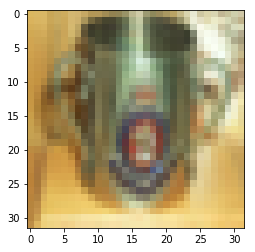

class: cup
label: 1


In [13]:
show_test_sample_info(100)

In [14]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers

/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [44]:
# なぜかエラー
#cnnの定義
class CNN(chainer.Chain): 
    def __init__(self): # 層の入力に対する処理を記述
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3,out_channels=64,ksize=4,stride=1,pad=2)
            self.conv2 = L.Convolution2D(in_channels=None,out_channels=128,ksize=4,stride=1,pad=2)
            self.conv3 = L.Convolution2D(in_channels=None,out_channels=128,ksize=4,stride=1,pad=2)
            self.fc1 = L.Linear(None,512)
            self.fc2 = L.Linear(None,5)
        
    def __call__(self, X): #　層の入力に対する結果を変換して次の層の入力を作り出す
        h = F.relu(F.max_pooling_2d(self.conv1(X),ksize=2)) #データXを畳み込みした後2x2のプーリングを経てreluにかける
        h = F.relu(F.max_pooling_2d(self.conv2(h),ksize=2))
        h = F.relu(F.max_pooling_2d(self.conv3(h),ksize=2))
        h = F.relu(self.fc1(h))
        return self.fc2(h)

In [21]:
# CNNの定義
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 5) # out_channelはクラス数と同じ5に設定
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [46]:
# tuple_datasetの型にしないといけない
from chainer.datasets import tuple_dataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators

In [47]:
model = L.Classifier(CNN()) #CNNインスタンスを引数にした識別器にmodelという名前をつける

#optimizerインスタンスの生成
optimizer = optimizers.SGD()
optimizer.setup(model) #modelに合わせる。

batchsize = 100
n_epoch = 100

In [48]:
# trainerを定義
train = tuple_dataset.TupleDataset(X_train,y_train)
train_iter = iterators.SerialIterator(train,batch_size=batchsize,shuffle=True)
updater = training.StandardUpdater(train_iter,optimizer)
trainer = training.Trainer(updater,(n_epoch,'epoch'),out = 'result')

In [49]:
# Extensionsを利用してtrainerの機能を拡張
test = tuple_dataset.TupleDataset(X_test,y_test)
test_iter = iterators.SerialIterator(test,batch_size=batchsize,shuffle=False,repeat=False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [50]:
trainer.run()

Exception in main training loop: 'CNN' object is not callable
Traceback (most recent call last):
  File "/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/chainer/training/trainer.py", line 299, in run
    update()
  File "/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/chainer/training/updater.py", line 223, in update
    self.update_core()
  File "/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/chainer/training/updater.py", line 234, in update_core
    optimizer.update(loss_func, *in_arrays)
  File "/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/chainer/optimizer.py", line 541, in update
    loss = lossfun(*args, **kwds)
  File "/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/chainer/links/model/classifier.py", line 114, in __call__
    self.y = self.predictor(*args, **kwargs)
Will finalize trainer extensions and updater before reraising the exception.


TypeError: 'CNN' object is not callable

In [27]:
# モデルを利用して予測をする関数を定義
def predict(model, X):
    if len(X.shape) == 3:  # データ数が1の場合は、バッチサイズ分の次元を追加
        pred = model.predictor(X[None, ...]).data.argmax()
    else:  # データ数が2以上の場合はそのまま
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

In [28]:
# 性能指標を確認
from sklearn import metrics
print('accuracy: %.3f' % metrics.accuracy_score(y_test, predict(model, X_test)))
print('recall: %.3f' % metrics.recall_score(y_test, predict(model, X_test), average='macro'))
print('precision: %.3f' % metrics.precision_score(y_test, predict(model, X_test), average='macro'))
print('f1_score: %.3f' % metrics.f1_score(y_test, predict(model, X_test), average='macro'))

accuracy: 0.750
recall: 0.750
precision: 0.764
f1_score: 0.748


In [29]:
# PlotReportによるグラフを出力する関数
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

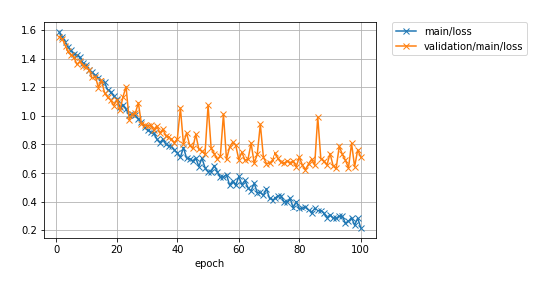

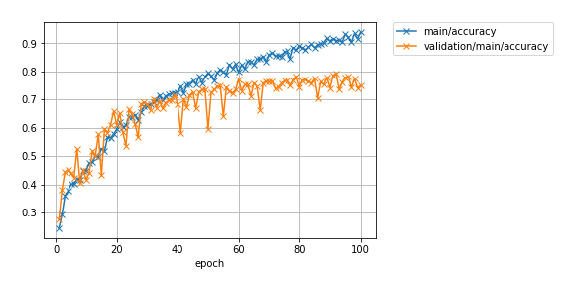

In [30]:
# 精度と誤差をグラフ描画
show_graph('result/loss.png')
show_graph('result/accuracy.png')

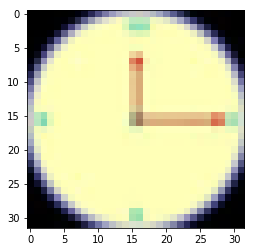

class: clock
label: 0
predict: 0
正解です｡


In [31]:
# indexを指定
index = 1

# 画像を出力
show_test_sample_info(index)

# 指定のindexが与えられたtestデータについて確認
pred = predict(model, X_test[index])
print('predict: {}'.format(pred))

# 正解か不正解かを出力
if pred == y_test[index]:
    print('正解です｡')
else:
    print('間違いです｡')

### 混同行列で間違いの傾向を確認する

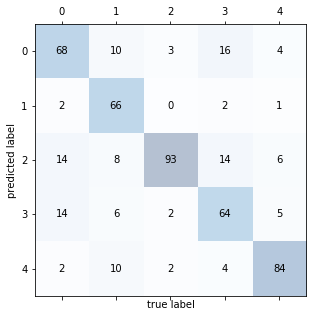

In [32]:
from sklearn.metrics import confusion_matrix as cm

# 混同行列きれいに出力する関数
def plot_cm(y_true, y_pred):
    confmat = cm(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xticks(np.arange(0, 5, 1))                               # x軸の目盛りを指定
    plt.yticks(np.arange(0, 5, 1))  
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    
# 混同行列を出力
result = predict(model, X_test)
plot_cm(result, y_test)

In [33]:
# 予測が外れたtestデータを格納するリストを用意
errors = []

# すべてのtestデータをチェック
for i in range(len(y_test)):
    pred_1 = predict(model, X_test[i])
    if pred_1 != y_test[i]:
        # (index, 正解ラベル, 予測ラベル)をタプル形式で格納
        errors.append((i, label[y_test[i]], label[pred_1]))

In [34]:
# 誤分類の総数を出力
len(errors)

125

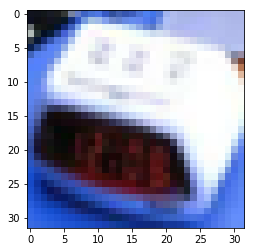

class: clock
label: 0
clock
television


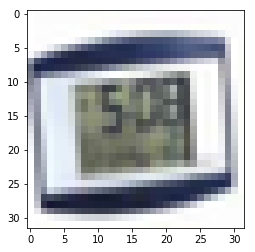

class: clock
label: 0
clock
television


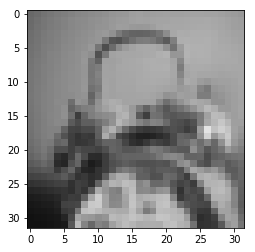

class: clock
label: 0
clock
bicycle


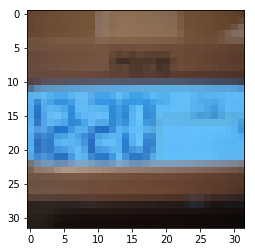

class: clock
label: 0
clock
television


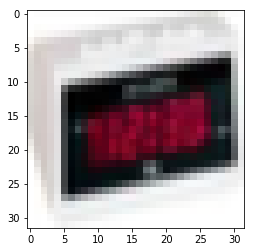

class: clock
label: 0
clock
television


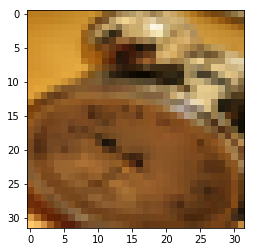

class: clock
label: 0
clock
bicycle


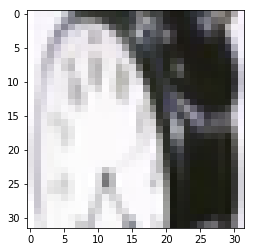

class: clock
label: 0
clock
cup


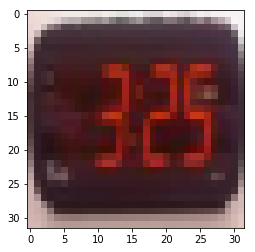

class: clock
label: 0
clock
television


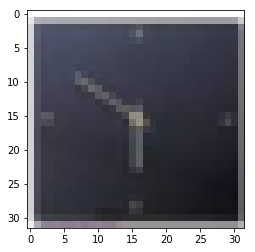

class: clock
label: 0
clock
television


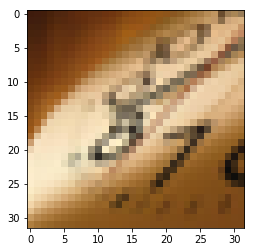

class: clock
label: 0
clock
bicycle


In [35]:
# 予測が外れた画像を集めて表示する
# 数が多いので3つだけ表示
for error_index, corr_label, pred_label in errors[:10]:
    show_test_sample_info(error_index)
    print(corr_label)
    print(pred_label)